In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

In [2]:
def report_params(fit_params_values, fit_param_names):
    for each in range(len(fit_param_names)):
        print(fit_param_names[each], 'is', fit_params_values[each])

# define your modules
def pCon1():
    # This is the module for a specific insubstatiation of a constituitive promoter
    # the input is nothing
    # the output is a protein production amount per time unit
    pCon1_production_rate = 10
    
    return pCon1_production_rate # MEFL minute**-1
    
def pLux1(LuxR, AHL):
    # This is the module for a specific insubstatiation of a lux promoter
    # the input is a LuxR amount and an AHL amount
    # the output is a protein production amount per time unit
    
    # For every promoter there is some function that determines what the promoter's
    #     maximal and basal expression are based on the amount of transcriptional factor
    #     is floating around in the cell. These numbers are empircally determined, and
    #     for demonstration purposes are fictionally and arbitrarily filled in here. 
    #     These functions take the form of hill functions.
    
    basal_n = 2
    basal_basal = 2
    basal_max = 4
    basal_kd = 2
    basal_expression_rate = basal_basal + (basal_max * (LuxR**basal_n / (LuxR**basal_n + basal_kd))) # MEFL minute**-1
    
    max_n = 2
    max_max = 600
    max_kd = 10
    maximal_expression_rate = max_max * (LuxR**max_n / (LuxR**max_n + max_kd)) # MEFL minute**-1
    
    
    pLux1_n = 2
    pLux1_kd = 10
     
    pLux1_production_rate = basal_expression_rate + (maximal_expression_rate * (AHL**pLux1_n / (pLux1_kd + AHL**pLux1_n))) 
    
    return pLux1_production_rate # MEFL minute**-1

def simulation_set_of_equations(current_species_concentration, dt):
    protein_loss = 0.01 # A summation of dilution and degredation
    
    # Unpack your current amount of each species
    LuxR, GFP, AHL = current_species_concentration
    
    # Determine the change in each species
    dLuxR = dt * (pCon1() - protein_loss*LuxR)
    dGFP = dt * (pLux1(LuxR, AHL) - protein_loss*GFP)
    dAHL = dt * 0 # for now we're assuming AHL was added exogenously and never degrades
    
    # Return the change in each species; make sure same order as your init values
    # scipy.odeint will take these values and apply them to the current value of each species in the next time step for you
    return [dLuxR, dGFP, dAHL]

In [8]:
def ODE(total_time, timesteps, species, system_of_equations):
    current_time = 0
    dt = total_time / timesteps
    
    # Store all the timepoints used. 
    timepoints = [] 
    
    # Create a list to store each species at each timepoint
    results = [] 
    for i in range(0, len(species)):
        results.append([])
        
    ########################
    #### Start ODE loop ####
    while current_time<total_time:
        # Log the amount of each species
        for i in range(0, len(species)):
            results[i].append(species[i])
        
        # Calculate the change in each species and apply it to the current
        change_in_species = simulation_set_of_equations(species, dt)
        species = np.add(species, change_in_species)

        # store current timpoint and then increment time
        timepoints.append(current_time)
        current_time += dt
    #### End ODE loop ####    
    ######################
    
    return timepoints, results

In [11]:
# %%timeit
# LuxR, GFP, AHL
initial_conditions = [10, 10, 100] # Initial Conditions
x, y = ODE(100, 1000, species, simulation_set_of_equations)

9.68 ms ± 76.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


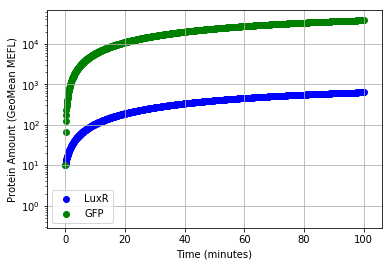

In [10]:
plt.scatter(x, y[0], c='b', label = 'LuxR')
plt.scatter(x, y[1], c='g', label = 'GFP')
#plt.scatter(timepoints, results[2], c='r', label = 'AHL')
plt.xlabel('Time (minutes)')
plt.ylabel('Protein Amount (GeoMean MEFL)')
plt.legend(loc = 'best')
plt.grid()
plt.yscale('log')
plt.show()